# Анализ данных 

## Подгружаем все, что пригодится

Подгрузим библиотеки

In [33]:
# !pip3 install pandas
# !pip3 install scipy
# !pip3 install numpy
# !pip3 install matplotlib
# !pip3 install seaborn
# !pip3 install scikit-learn
# !pip3 install catboost
# !pip3 install optuna

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# библиотеки 
import pandas as pd
# from scipy import stats
import numpy as np
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# мои файлы
import tune_model
from psi_test import calculate_psi
from data_process import load_data

In [8]:
# загрузим данные
data = load_data()
data.head()

/Users/aksveronika/Desktop/Курсовая/data_process.py:11: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  data3 = pd.read_csv('/Users/aksveronika/Desktop/Курсовая/analogs_2023-05-31_2023-06-30.csv')


,Unnamed: 0,a_offer_id,a_actual_dt,a_n_photos,a_source,a_house_guid,a_house_lat,a_house_lon,a_floor,a_rooms,...,b_flat_class_mean,b_is_apartment_mean,b_region,b_amenities,b_infrastructure,b_commission,b_deposit,b_haggle,b_communal_payments,a_price
0,0,1716056981,2023-04-05 18:57:39,13,2,3f1e2c9c-b077-4d9a-87e5-dea3a194fce2,59.984094,30.212948,8,1,...,2.28,0.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,35000.0
1,1,1716380878,2023-04-08 18:56:30,14,1,b9fbe34e-3820-4ab3-8bca-d30836ded4d5,59.982910,30.225156,3,2,...,3.32,0.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,60000.0
2,2,1707933885,2023-04-07 17:50:13,12,1,b9fbe34e-3820-4ab3-8bca-d30836ded4d5,59.982910,30.225156,8,1,...,3.32,0.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,50000.0
3,3,1680995097,2023-04-03 19:26:13,10,1,4a353fc0-e1c3-4f4b-af87-ef6bcc016c17,59.983504,30.219605,18,2,...,3.43,0.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,36000.0
4,4,1718295254,2023-04-11 19:27:40,24,0,df5ffe13-4283-47ce-8aea-933a13c86dd1,59.987654,30.207549,8,2,...,3.57,0.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,49000.0


## Простые статистики

### Число наблюдений

In [9]:
print(f'Всего пар объектов-аналогов: {data.groupby(["a_offer_id", "b_offer_id"]).size().reset_index().shape[0]}')

Всего пар объектов-аналогов: 8589466


In [10]:
print(f'Уникальных объектов: { data["a_offer_id"].nunique()}')
print(f'Уникальных аналогов: { data["b_offer_id"].nunique()}')

combined_offer_ids = data['a_offer_id'].tolist() + data['b_offer_id'].tolist()
unique_combined_offer_ids = len(set(combined_offer_ids))
print(f'Уникальных квартир всего: {unique_combined_offer_ids}')

Уникальных объектов: 49451
Уникальных аналогов: 70633
Уникальных квартир всего: 71494


### Даты

In [11]:
data['a_actual_dttm'] = data['a_actual_dt']
data['a_actual_dt'] = pd.to_datetime(data['a_actual_dt']).dt.date

In [12]:
min_date = data['a_actual_dt'].min()
max_date = data['a_actual_dt'].max()
print(f'Минимальная дата: {min_date}')
print(f'Максимальная дата: {max_date}')

Минимальная дата: 2023-04-01
Максимальная дата: 2023-10-30


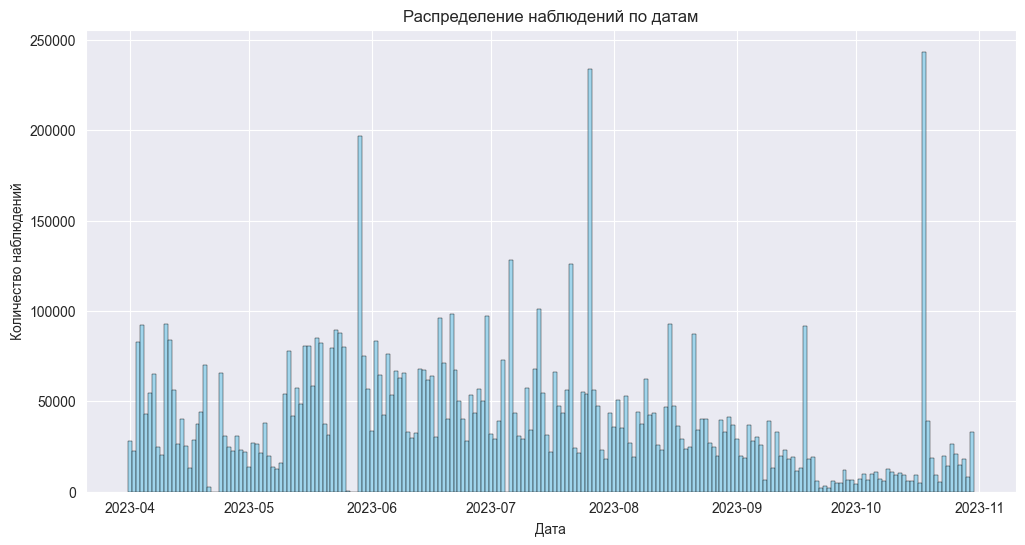

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(data['a_actual_dt'], bins=30, color='skyblue', edgecolor='black', kde=False)
plt.title('Распределение наблюдений по датам')
plt.xlabel('Дата')
plt.ylabel('Количество наблюдений')
plt.show()

## График изменения по времени

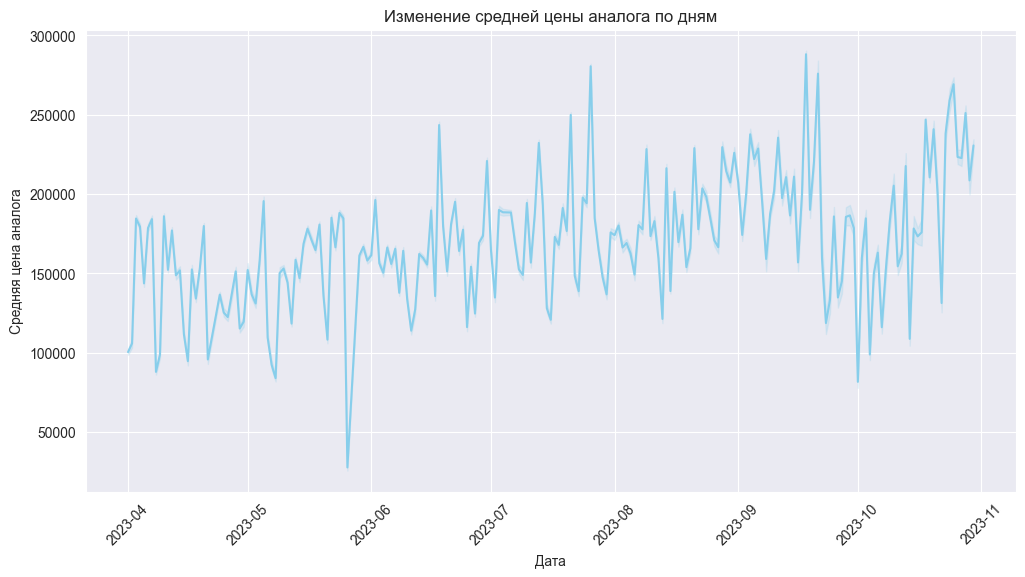

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='a_actual_dt', y='b_price', color='skyblue', data=data, estimator='mean', errorbar=('ci', 99))
plt.title('Изменение средней цены аналога по дням')
plt.xlabel('Дата')
plt.ylabel('Средняя цена аналога')
plt.xticks(rotation=45)
plt.show()

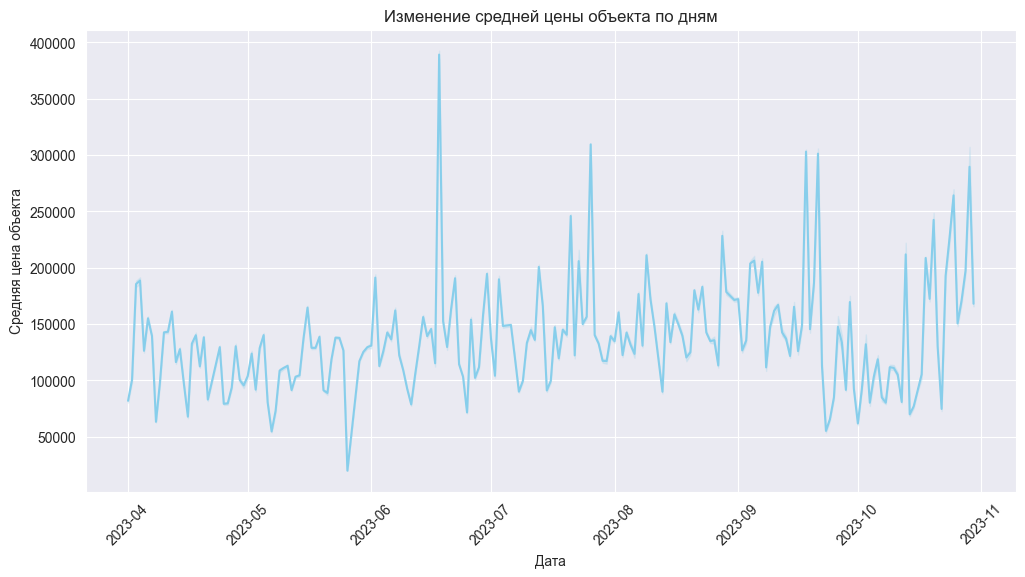

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='a_actual_dt', y='a_price', color='skyblue', data=data, estimator='mean', errorbar=('ci', 99))
plt.title('Изменение средней цены объекта по дням')
plt.xlabel('Дата')
plt.ylabel('Средняя цена объекта')
plt.xticks(rotation=45)
plt.show()

У объекта и аналога прослеживается тренд роста до 2023-10. В октябре 2023 года падение и затем снова роста

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589466 entries, 0 to 8589465
Data columns (total 75 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unnamed: 0                      int64  
 1   a_offer_id                      int64  
 2   a_actual_dt                     object 
 3   a_n_photos                      int64  
 4   a_source                        int64  
 5   a_house_guid                    object 
 6   a_house_lat                     float64
 7   a_house_lon                     float64
 8   a_floor                         int64  
 9   a_rooms                         int64  
 10  a_renovation                    float64
 11  a_repair_class_id               float64
 12  a_quality_class_id              float64
 13  a_quality                       float64
 14  a_balconies                     float64
 15  a_loggias                       float64
 16  a_area_total                    float64
 17  a_living_area              

## Есть ли выбросы

Предположим, что у нас есть квартиры с аномально низкими или аномально высокими ценами. Создадим df со списком всех квартир (и объектов и аналогов)

In [17]:
data_union = pd.DataFrame({'offer_id': data['a_offer_id'].tolist() + data['b_offer_id'].tolist(),
                       'price': data['a_price'].tolist() + data['b_price'].tolist()}).drop_duplicates()
data_union.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93071 entries, 0 to 17178487
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   offer_id  93071 non-null  int64  
 1   price     93071 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.1 MB


### Разные цены на одну квартиру

In [18]:
multiple_prices = data_union.groupby('offer_id')['price'].nunique()
offer_id_multiple_prices = multiple_prices[multiple_prices > 1].index.tolist()
print(f'Offer_id у которых несколько цен: {offer_id_multiple_prices}')

Offer_id у которых несколько цен: [109116936, 364990353, 412937852, 412938029, 412938113, 412938299, 412938490, 413325730, 440575711, 605176894, 699466760, 780750155, 812717633, 819532415, 822825805, 940062235, 963373967, 990879255, 1030263835, 1034157238, 1051797486, 1103761131, 1171219822, 1180007401, 1191944220, 1196938005, 1197517557, 1202746466, 1217436414, 1220078791, 1220078826, 1220078841, 1220079129, 1220079181, 1220079374, 1220322187, 1227337633, 1228383789, 1233307211, 1234612864, 1235912174, 1236657870, 1237978163, 1240594370, 1243157372, 1255214877, 1258164450, 1261002900, 1269204737, 1284220840, 1284247207, 1285188601, 1289834740, 1291647899, 1291801111, 1300686554, 1303651572, 1307416215, 1307486030, 1317068632, 1317193850, 1326941495, 1326941913, 1331493846, 1333327461, 1334831262, 1335446345, 1339342696, 1344299313, 1344705973, 1349073836, 1350790582, 1354330669, 1355812986, 1357450729, 1358363394, 1360559485, 1360570891, 1361434056, 1362937378, 1374494545, 1379683807,

In [19]:
data[(data['b_offer_id'] == 109116936) & (data['b_price'] != 843249)][['b_offer_id', 'b_price', 'b_valid_from', 'b_valid_to']]

,b_offer_id,b_price,b_valid_from,b_valid_to
919220,109116936,817441.0,2023-04-11 18:34:25,2023-04-12 18:34:40
919221,109116936,817441.0,2023-04-11 18:34:25,2023-04-12 18:34:40
919222,109116936,817441.0,2023-04-11 18:34:25,2023-04-12 18:34:40
919223,109116936,816279.0,2023-04-18 18:34:41,2023-04-19 18:35:09
919224,109116936,814863.0,2023-04-24 18:34:38,2023-04-24 19:23:33
...,...,...,...,...
4051505,109116936,809657.0,2023-06-02 18:34:44,2023-06-03 18:35:23
4051506,109116936,809657.0,2023-06-02 18:34:44,2023-06-03 18:35:23
4051507,109116936,809657.0,2023-06-02 18:34:44,2023-06-03 18:35:23
4051508,109116936,809657.0,2023-06-02 18:34:44,2023-06-03 18:35:23


У аналогов цена меняется со временем. Но за 1 временной период - цена одна

Проверим цены у объектов

In [20]:
multiple_prices = data.groupby('a_offer_id')['a_price'].nunique()
offer_id_multiple_prices = multiple_prices[multiple_prices > 1].index.tolist()
print(f'Offer_id у которых несколько цен: {offer_id_multiple_prices}')

Offer_id у которых несколько цен: []


У объектов цена фиксированная

### Выбросы в ценах квартир

Посмотрим на выбросы в ценах всех квартир. За уникальную пару будем считаь offer_id + price

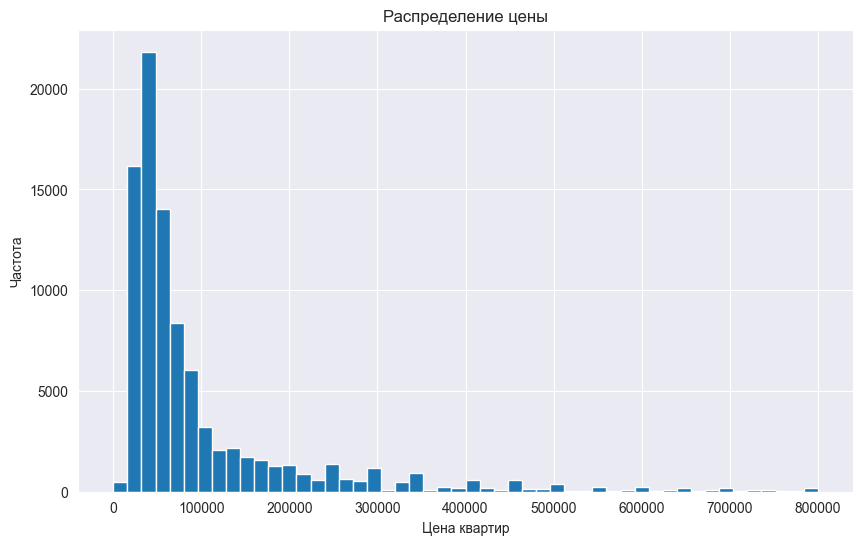

Среднее: 125166.38391120757
Медиана: 55000.0
Стандартное отклонение: 240282.9264914249
-72500.0 и 219500.0
Количество выбросов: 12417


In [28]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.hist(data_union['price'], bins=50, range=(0, 800000))
plt.xlabel('Цена квартир')
plt.ylabel('Частота')
plt.title('Распределение цены')
plt.show()

# Расчет статистик
mean_diff = data_union['price'].mean()
median_diff = data_union['price'].median()
std_diff = data_union['price'].std()

print(f'Среднее: {mean_diff}')
print(f'Медиана: {median_diff}')
print(f'Стандартное отклонение: {std_diff}')

# Поиск выбросов с помощью межквартильного интервала
Q1 = data_union['price'].quantile(0.25)
Q3 = data_union['price'].quantile(0.75)
IQR = Q3 - Q1
print(f'{Q1 - 1.5 * IQR} и {Q3 + 1.5 * IQR}')
outliers = data_union[(data_union['price'] < (Q1 - 1.5 * IQR)) | (data_union['price'] > (Q3 + 1.5 * IQR))]

print(f'Количество выбросов: {len(outliers)}')

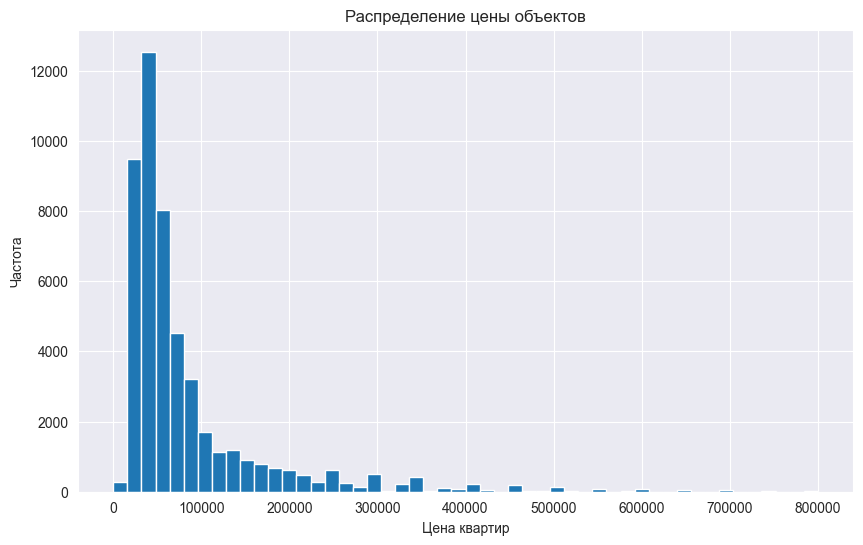

Среднее: 90063.17631594912
Медиана: 50000.0
Стандартное отклонение: 133574.5521533466
-47500.0 и 172500.0
Количество выбросов: 5752


In [31]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.hist(data[['a_offer_id', 'a_price']].drop_duplicates()['a_price'], bins=50, range=(0, 800000))
plt.xlabel('Цена квартир')
plt.ylabel('Частота')
plt.title('Распределение цены объектов')
plt.show()

df = data[['a_offer_id', 'a_price']].drop_duplicates()

# Расчет статистик
mean_diff = df['a_price'].mean()
median_diff = df['a_price'].median()
std_diff = df['a_price'].std()

print(f'Среднее: {mean_diff}')
print(f'Медиана: {median_diff}')
print(f'Стандартное отклонение: {std_diff}')

# Поиск выбросов с помощью межквартильного интервала
Q1 = df['a_price'].quantile(0.25)
Q3 = df['a_price'].quantile(0.75)
IQR = Q3 - Q1
print(f'{Q1 - 1.5 * IQR} и {Q3 + 1.5 * IQR}')
outliers = df[(df['a_price'] < (Q1 - 1.5 * IQR)) | (df['a_price'] > (Q3 + 1.5 * IQR))]

print(f'Количество выбросов: {len(outliers)}')

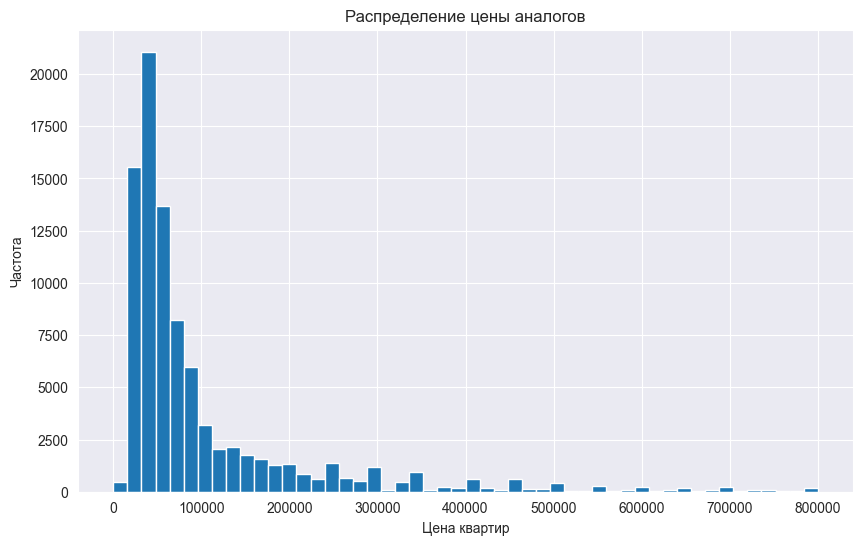

Среднее: 126840.84509146844
Медиана: 55000.0
Стандартное отклонение: 242524.56157080174
-80000.0 и 232000.0
Количество выбросов: 11393


In [32]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.hist(data[['b_offer_id', 'b_price']].drop_duplicates()['b_price'], bins=50, range=(0, 800000))
plt.xlabel('Цена квартир')
plt.ylabel('Частота')
plt.title('Распределение цены аналогов')
plt.show()

df = data[['b_offer_id', 'b_price']].drop_duplicates()

# Расчет статистик
mean_diff = df['b_price'].mean()
median_diff = df['b_price'].median()
std_diff = df['b_price'].std()

print(f'Среднее: {mean_diff}')
print(f'Медиана: {median_diff}')
print(f'Стандартное отклонение: {std_diff}')

# Поиск выбросов с помощью межквартильного интервала
Q1 = df['b_price'].quantile(0.25)
Q3 = df['b_price'].quantile(0.75)
IQR = Q3 - Q1
print(f'{Q1 - 1.5 * IQR} и {Q3 + 1.5 * IQR}')
outliers = df[(df['b_price'] < (Q1 - 1.5 * IQR)) | (df['b_price'] > (Q3 + 1.5 * IQR))]

print(f'Количество выбросов: {len(outliers)}')

Проверим, что не бывает цена < 0

In [ ]:
data_union[data_union['price'] < 0]

,offer_id,price


### Разница в цене объекта и аналога

Мы нашли цену квартиры, выше которой могли бы предположить, что этот объект - выброс. Однако для Москвы цена в 240.000 это не предел. Не хотелось бы выкидывать такие квартиры, так как потом мы будем хуже предсказывать цену для объектов этой ценовой категории.

Можем поробовать:
1) для модели бейзлайна убрать аналоги с очень большой стоимостью 
2) для модели корректировок при обучении убирать квартиры с аномально высокой ценой среди аналогов/объектов/аналогов+объектов

Давайте рассмотрим разницу между ценой объекта и аналога. Слишком большая разница может указывать на то, что эта пара - выброс.

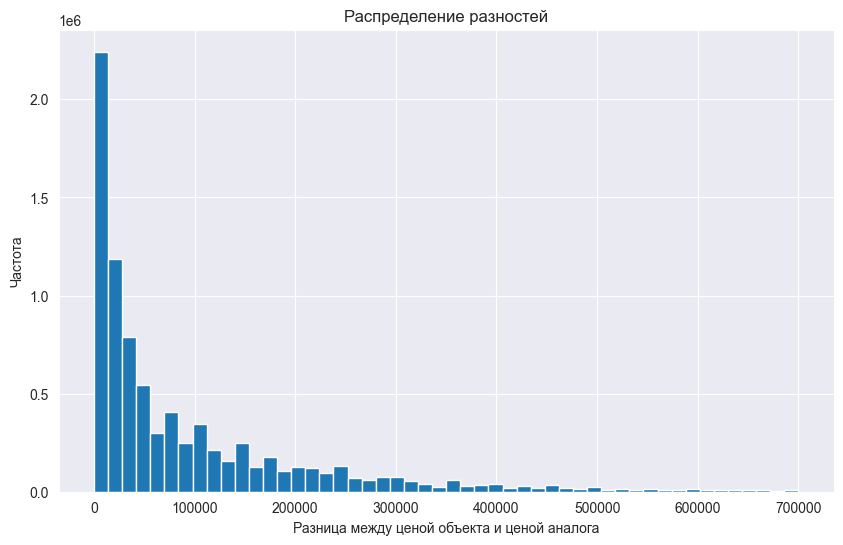

Средняя разница: 117343.02143416133
Медиана разницы: 45000.0
Стандартное отклонение разницы: 220100.41995267107


Количество выбросов: 661506


In [ ]:
# Построение графика разности
plt.figure(figsize=(10, 6))
plt.hist(data['price_diff'], bins=50, range=(-10, 700000))
plt.xlabel('Разница между ценой объекта и ценой аналога')
plt.ylabel('Частота')
plt.title('Распределение разностей')
plt.show()

# Расчет статистик
mean_diff = data['price_diff'].mean()
median_diff = data['price_diff'].median()
std_diff = data['price_diff'].std()

print(f'Средняя разница: {mean_diff}')
print(f'Медиана разницы: {median_diff}')
print(f'Стандартное отклонение разницы: {std_diff}')

# Поиск выбросов с помощью межквартильного интервала
Q1 = data['price_diff'].quantile(0.25)
Q3 = data['price_diff'].quantile(0.75)
IQR = Q3 - Q1
price_outliers = data[(data['price_diff'] < (Q1 - 1.5 * IQR)) | (data['price_diff'] > (Q3 + 1.5 * IQR))]

print(f'Количество выбросов: {len(price_outliers)}')

Посмотрим примеры квартир с большой разницей в цене

In [ ]:
price_outliers[['a_price', 'b_price']].drop_duplicates().head(8)

,a_price,b_price
50,400000.0,65000.0
53,500000.0,65000.0
82,500000.0,110000.0
131,500000.0,85000.0
258,450000.0,74000.0
410,500000.0,80000.0
467,500000.0,90000.0
738,450000.0,90000.0


In [ ]:
print(f"Средняя разница выбросов: {abs((price_outliers['a_price'] - price_outliers['b_price']).mean())}")

Средняя разница выбросов: 192852.51510341553


Аналогично, для моделей можем попробовать выкидывать пары с сильной разницей цен

Для этого в data_process при обработке входных данных сделаем новые поля, как флаги потенциальных выбросов

In [ ]:
df_cleaned = df[~df['diff'].isin(outliers['diff'])]
df_cleaned = df.copy(deep=True)

# Подготовка выборок

## Критерий и подход к формированию выборок

Данные мы отсотируем по a_actual_date - актуальной цене аналога (дата, до которой висело объявление).

Разбивать на фолды будем последовательно по датам: сначала train, затем val, потом test в отношении 80/10/10.

Такая сортировка необходима, чтобы избежать утечки данных их будущего в прошлого, так как для реального предсказания мы всегда будем использовать данные, натренированные на прошлых цена, для предсказания цен аренды в будущем.

## Размер выборок

Теперь можем подготовить train, val и test выборки. 

In [ ]:
objects_sorted_dt = data.sort_values(by='a_actual_dt')['a_offer_id'].drop_duplicates()


# Определяем точки, на которых нужно разделить данные
train_size = int(len(objects_sorted_dt) * 0.8)  # 80% данных для обучения
val_size = int(len(objects_sorted_dt) * 0.1)  # 10% данных для валидации
test_size = len(objects_sorted_dt) - train_size - val_size  # Оставшиеся 10% данных для теста

# Разделяем на обучающую, валидационную и тестовую выборки
obejcts_train = objects_sorted_dt[:train_size]
obejcts_val = objects_sorted_dt[train_size:train_size + val_size]
obejcts_test = objects_sorted_dt[train_size + val_size:]

train = pd.merge(data, obejcts_train, on='a_offer_id', how='inner')
test = pd.merge(data, obejcts_test, on='a_offer_id', how='inner')
val = pd.merge(data, obejcts_val, on='a_offer_id', how='inner')

print("Размер train выборки:", len(train))
print("Размер val выборки:", len(val))
print("Размер test выборки:", len(test))

print("Размер train выборки объектов:", len(train['a_offer_id'].drop_duplicates()))
print("Размер val выборки объектов:", len(val['a_offer_id'].drop_duplicates()))
print("Размер test выборки объектов:", len(test['a_offer_id'].drop_duplicates()))

Размер train выборки: 7770970
Размер val выборки: 489963
Размер test выборки: 328533
Размер train выборки объектов: 39560
Размер val выборки объектов: 4945
Размер test выборки объектов: 4946


Далее результаты мы будем считать на тестовой выборке, а подбирать лучшую модель на тренировочной

# Анализ бейзлайна на средних

Описание подхода бейзлайна на средних:

Для каждой квартиры объекта мы считаем среднюю цену подобранных квартир аналогов. Это и будет наша предсказанная стоимость цены квартиры-объекта.

С этим показателем мы будем сранивать итоговый результат модели

In [ ]:
# Вычисление MAPE
def mean_absolute_percentage_error_value(y_true, y_pred): 
    return (abs((y_true - y_pred) / y_true) * 100)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Посчитаем модель бейзлайна без преобразований

In [ ]:
from baseline_model import MeansModel
from metric import mean_absolute_percentage_error_value, mean_absolute_percentage_error

baseline_model = MeansModel()
baseline_model.predict(train)

,a_offer_id,a_price,target_price,MAPE
0,16309055,380000.0,299090.616558,21.291943
1,109116854,225000.0,434727.925770,93.212411
2,109116931,230000.0,248277.635063,7.946798
3,109116936,843249.0,281863.301151,66.574132
4,109116967,450000.0,295621.260070,34.306387
...,...,...,...,...
39555,1854174251,49000.0,44765.217391,8.642413
39556,1854174255,60000.0,66945.945946,11.576577
39557,1854216725,19000.0,41576.923077,118.825911
39558,1854428704,28000.0,47403.602410,69.298580


In [ ]:
baseline_model.calculate_metric(baseline_model.predict(train)), baseline_model.calculate_metric(baseline_model.predict(test))

(54.4215954242779, 55.05556392367663)

## Наличие выбросов целевой метрики (MAPE) 

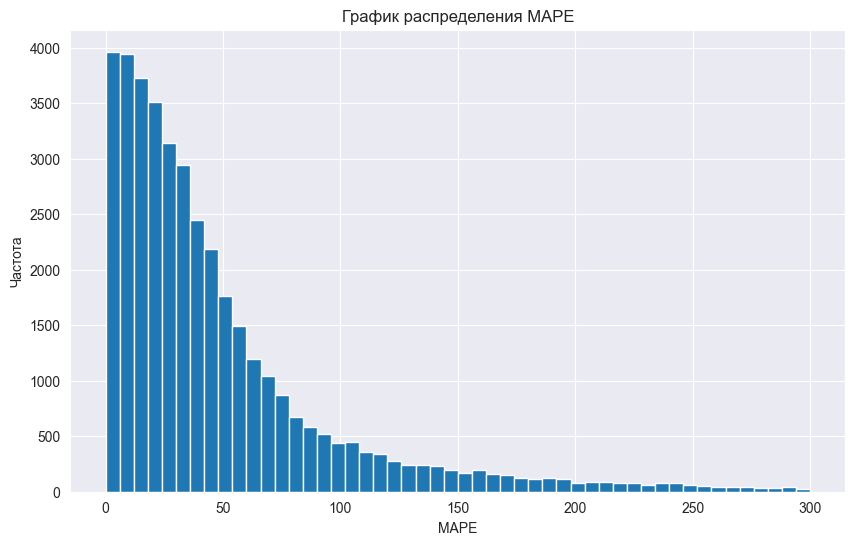

-56.039972779169304 и 133.78538880561828
Количество выбросов: 3380


In [ ]:
df_mape = baseline_model.predict(train)

# Построение графика разности
plt.figure(figsize=(10, 6))
plt.hist(df_mape['MAPE'], bins=50, range=(0, 300))

plt.xlabel('MAPE')
plt.ylabel('Частота')
plt.title('График распределения MAPE')
plt.show()

# Поиск выбросов с помощью межквартильного интервала
Q1 = df_mape['MAPE'].quantile(0.25)
Q3 = df_mape['MAPE'].quantile(0.75)
IQR = Q3 - Q1
print(f'{Q1 - 1.5 * IQR} и {Q3 + 1.5 * IQR}')
outliers_MAPE = df_mape[(df_mape['MAPE'] < (Q1 - 1.5 * IQR)) | (df_mape['MAPE'] > (Q3 + 1.5 * IQR))]

print(f'Количество выбросов: {len(outliers_MAPE)}')

Попробуем посчитать итоговую метрику, если мы избавимся от выбросов

In [ ]:
print(len(data['a_offer_id'].drop_duplicates()))
data_price_cleaned = data[~data['price_diff'].isin(price_outliers['price_diff'])]
print(len(data_price_cleaned['a_offer_id'].drop_duplicates()))

49451


49440


### Сколько аналогов на объект:

In [ ]:
data[['a_offer_id', 'b_offer_id']].drop_duplicates().groupby('a_offer_id').count().reset_index()

,a_offer_id,b_offer_id
0,16309055,459
1,109116854,714
2,109116931,559
3,109116936,1129
4,109116967,1142
...,...,...
49446,1919093508,47
49447,1919492491,25
49448,1920033504,11
49449,1920394890,6


In [ ]:
data[['a_offer_id', 'b_offer_id']].drop_duplicates().groupby('a_offer_id').count().reset_index()['b_offer_id'].mean()

173.69650765404137

### MAPE и дисперсия в разрезе максимально допустимого количества аналогов

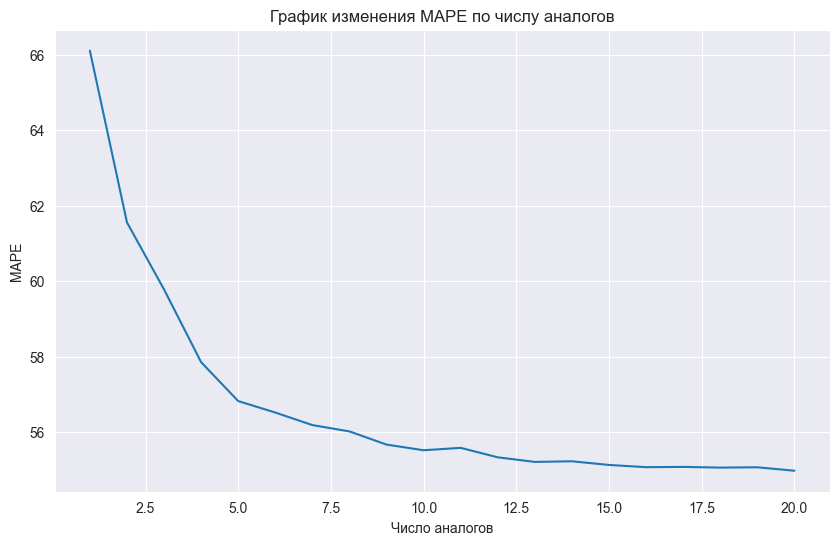

[66.10723008335877,
 61.55714667287183,
 59.7803081953019,
 57.85288389974578,
 56.82168857660087,
 56.51788597932577,
 56.185379936744695,
 56.01778865782919,
 55.66822295541248,
 55.5182645625926,
 55.581873322727574,
 55.330916404076504,
 55.20912876927305,
 55.225987098821626,
 55.12866718585017,
 55.06968964752224,
 55.07719871580866,
 55.05836160430736,
 55.06690711901842,
 54.97575316699389]

In [ ]:
from baseline_model import MeansModel

baseline_model = MeansModel(find_analogs_num=range(1, 21))
baseline_model.fit(train, title='График изменения MAPE по числу аналогов')


Если мы берем рандомные аналоги, то не стоит ограничивать их число. Чем больше, тем лучше

## МАРЕ и дисперсия после сортировки по отклонению по площади:

### В разрезе максимально допустимого количества аналогов

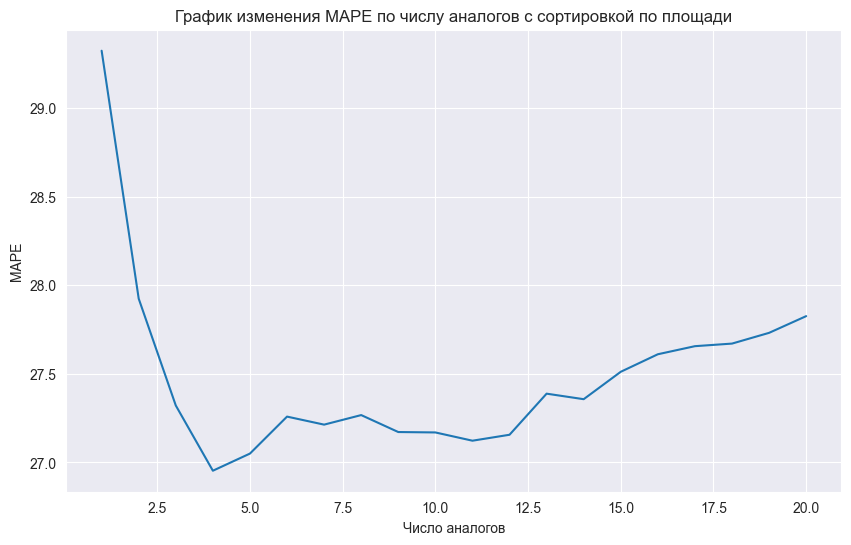

In [ ]:
from baseline_model import MeansModel

baseline_model = MeansModel(find_analogs_num=range(1, 21), sort_by=['area_total_diff'])
mape_grid = baseline_model.fit(train, title='График изменения MAPE по числу аналогов с сортировкой по площади')

In [ ]:
min_value = min(mape_grid)
min_index = mape_grid.index(min_value)
print(f'best MAPE: {min_value}')
print(f'best analogs_num: {range(1, 21)[min_index]}')

best MAPE: 26.95301618574052
best analogs_num: 4


### Покрытие в разрезе максимально допустимого отклонения по площади

In [ ]:
# выводим минимальное отклонение для каждого объекта

train.groupby('a_offer_id')['area_total_diff'].min().reset_index().sort_values(by='area_total_diff', ascending=False).head(15)

,a_offer_id,area_total_diff
292,1429239338,359.0
21236,1774786672,203.0
936,1539795318,180.0
21185,1774693662,147.5
10228,1726443865,143.0
1183,1552463716,140.0
4296,1688930933,135.0
4773,1694421648,126.0
36233,1827997489,124.0
7269,1711096423,119.0


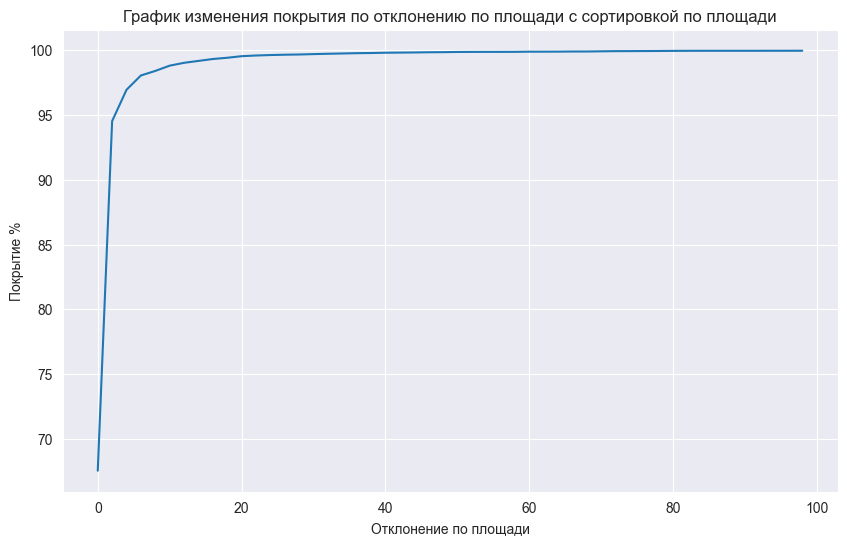

In [ ]:
from baseline_model import MeansModel

baseline_model = MeansModel(find_max_area_diff=range(0, 100, 2), sort_by=['area_total_diff'], coverage=True)
mape_grid, coverage_grid = baseline_model.fit(train, title='График изменения покрытия по отклонению по площади с сортировкой по площади')


In [ ]:
print(f'Максимальное отклонение по площади, при котором мы покрываем >= 99% объектов: {6}')

Максимальное отклонение по площади, при котором мы покрываем >= 99% объектов: 6


### В разрезе максимально допустимого отклонения по площади

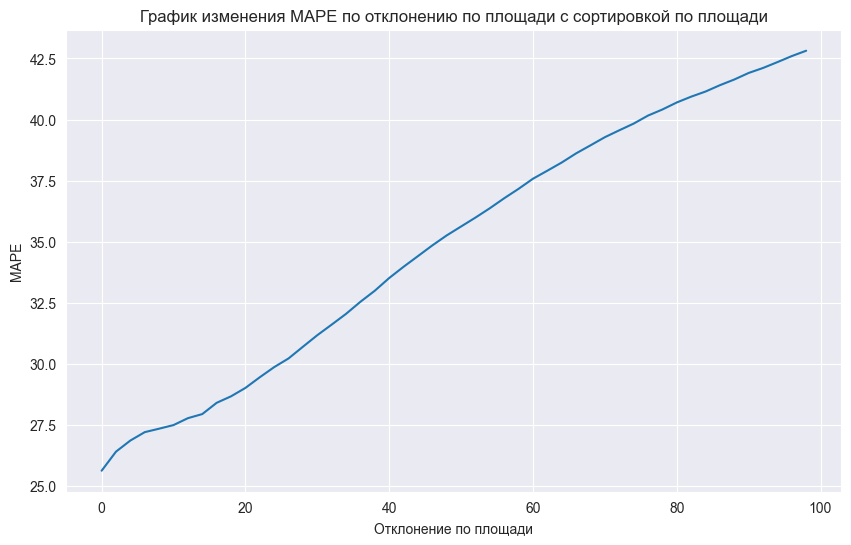

In [ ]:
from baseline_model import MeansModel

baseline_model = MeansModel(find_max_area_diff=range(0, 100, 2), sort_by=['area_total_diff'])
mape_grid, coverage_grid = baseline_model.fit(train, title='График изменения MAPE по отклонению по площади с сортировкой по площади')


In [ ]:
min_value = min(mape_grid)
min_index = mape_grid.index(min_value)
print(f'best MAPE: {min_value}')
print(f'best max_area_total_diff: {range(0, 100, 2)[min_index]}')

best MAPE: 25.62651525210481
best max_area_total_diff: 0


### В разрезе максимально допустимого количества аналогов с сортировкой по ремонту, площади

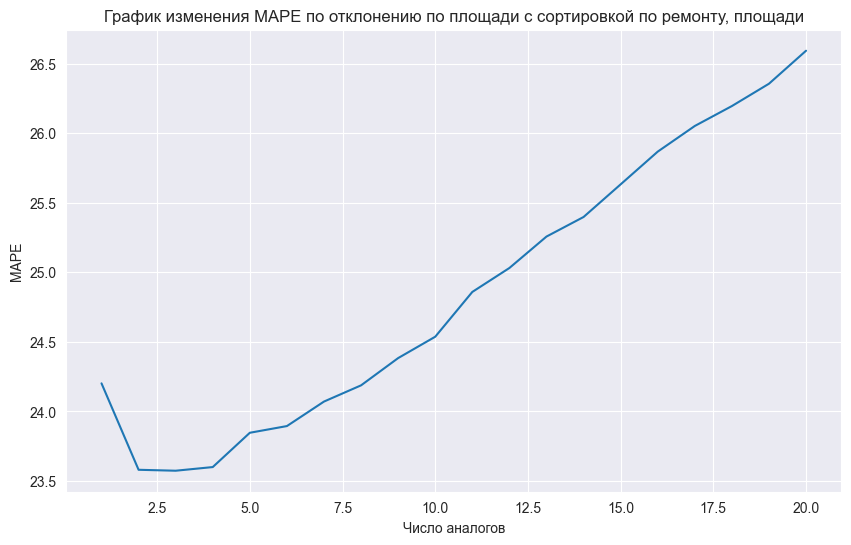

In [ ]:
from baseline_model import MeansModel

baseline_model = MeansModel(find_analogs_num=range(1, 21), sort_by=['repair_class_id_diff', 'area_total_diff'])
mape_grid = baseline_model.fit(train, title='График изменения MAPE по отклонению по площади с сортировкой по ремонту, площади')

In [ ]:
min_value = min(mape_grid)
min_index = mape_grid.index(min_value)
print(f'best MAPE: {min_value}')
print(f'best analogs_num: {range(1, 21)[min_index]}')

best MAPE: 23.574223916139562
best analogs_num: 3


In [ ]:
baseline_model = MeansModel(analogs_num=3, sort_by=['repair_class_id_diff', 'area_total_diff'])
baseline_model.calculate_metric(baseline_model.predict(test))


26.604019702058107

In [ ]:
baseline_model = MeansModel(analogs_num=3, sort_by=['quality_class_id_diff', 'area_total_diff'], agg_function='mean')
baseline_model.calculate_metric(baseline_model.predict(test))

26.759243042421204

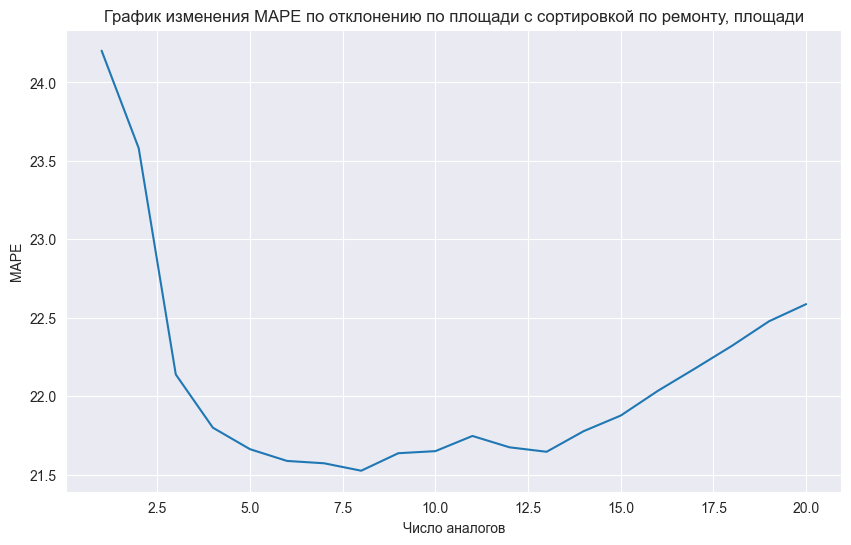

In [ ]:
from baseline_model import MeansModel

baseline_model = MeansModel(find_analogs_num=range(1, 21), sort_by=['repair_class_id_diff', 'area_total_diff'], agg_function='median')
mape_grid = baseline_model.fit(train, title='График изменения MAPE по отклонению по площади с сортировкой по ремонту, площади')

In [ ]:
min_value = min(mape_grid)
min_index = mape_grid.index(min_value)
print(f'best MAPE: {min_value}')
print(f'best analogs_num: {range(1, 21)[min_index]}')

best MAPE: 21.525216394501
best analogs_num: 8


In [ ]:
baseline_model = MeansModel(analogs_num=8, sort_by=['quality_class_id_diff', 'area_total_diff'], agg_function='median')
baseline_model.calculate_metric(baseline_model.predict(test))

24.182094510671526

## PSI-тест для признаков

In [ ]:
feature_columns = ['a_n_photos', 'a_source', 'a_floor', 'a_rooms',]
psi_values = {}

for col in feature_columns:
    psi = calculate_psi(train[col], test[col])
    psi_values[col] = psi

# фильтрация признаков по psi
filtered_features = {feature: psi for feature, psi in psi_values.items() if psi < 0.2} 
filtered_features

{'a_n_photos': 0.008369626298601789,
 'a_source': 0.00013689772984232037,
 'a_floor': 0.0004355358669489814,
 'a_rooms': 0.007099987679780188}

# Предобработка данных для модели корректирвок		

Создадим таблицу со всеми квартирами: объектами и аналогами

In [ ]:
data.columns

Index(['Unnamed: 0', 'a_offer_id', 'a_actual_dt', 'a_n_photos', 'a_source',
       'a_house_guid', 'a_house_lat', 'a_house_lon', 'a_floor', 'a_rooms',
       'a_renovation', 'a_repair_class_id', 'a_quality_class_id', 'a_quality',
       'a_balconies', 'a_loggias', 'a_area_total', 'a_living_area',
       'a_kitchen_area', 'a_built_year_fillna_own',
       'a_built_year_fillna_sim_low', 'a_entrance_count', 'a_elevators_count',
       'a_floors_fillna_own', 'a_wall_material_fillna_own',
       'a_wall_material_fillna_sim_low', 'a_ceiling_height_fillna_own',
       'a_flat_class_mean', 'a_is_apartment_mean', 'a_region', 'a_amenities',
       'a_infrastructure', 'a_commission', 'a_deposit', 'a_haggle',
       'a_communal_payments', 'b_offer_id', 'b_valid_from', 'b_valid_to',
       'b_price', 'b_n_photos', 'b_source', 'b_house_guid', 'b_house_lat',
       'b_house_lon', 'b_floor', 'b_rooms', 'b_renovation',
       'b_repair_class_id', 'b_quality_class_id', 'b_quality', 'b_balconies',
      

In [ ]:
object_features = ['a_offer_id', 'a_price', 'a_n_photos', 'a_source',
       'a_house_guid', 'a_house_lat', 'a_house_lon', 'a_floor', 'a_rooms',
       'a_renovation', 'a_repair_class_id', 'a_quality_class_id', 'a_quality',
       'a_balconies', 'a_loggias', 'a_area_total', 'a_living_area',
       'a_kitchen_area', 'a_built_year_fillna_own',
       'a_built_year_fillna_sim_low', 'a_entrance_count', 'a_elevators_count',
       'a_floors_fillna_own', 'a_wall_material_fillna_own',
       'a_wall_material_fillna_sim_low', 'a_ceiling_height_fillna_own',
       'a_flat_class_mean', 'a_is_apartment_mean', 'a_region', 'a_amenities',
       'a_infrastructure', 'a_commission', 'a_deposit', 'a_haggle',
       'a_communal_payments']

analog_features = ['b_offer_id', 'b_price', 'b_n_photos', 'b_source', 'b_house_guid', 'b_house_lat',
       'b_house_lon', 'b_floor', 'b_rooms', 'b_renovation',
       'b_repair_class_id', 'b_quality_class_id', 'b_quality', 'b_balconies',
       'b_loggias', 'b_area_total', 'b_living_area', 'b_kitchen_area',
       'b_built_year_fillna_own', 'b_built_year_fillna_sim_low',
       'b_entrance_count', 'b_elevators_count', 'b_floors_fillna_own',
       'b_wall_material_fillna_own', 'b_wall_material_fillna_sim_low',
       'b_ceiling_height_fillna_own', 'b_flat_class_mean',
       'b_is_apartment_mean', 'b_region', 'b_amenities', 'b_infrastructure',
       'b_commission', 'b_deposit', 'b_haggle', 'b_communal_payments',
       ]

object_features_dict = {}
analogs_features_dict = {}
for feature in object_features:
    object_features_dict[feature] = feature[2:]
for feature in analog_features:
    analogs_features_dict[feature] = feature[2:]

objects = data[object_features]
analogs = data[analog_features]

objects = objects.rename(columns=object_features_dict)
analogs = analogs.rename(columns=analogs_features_dict)


In [ ]:
analogs.head()

,offer_id,price,n_photos,source,house_guid,house_lat,house_lon,floor,rooms,renovation,...,ceiling_height_fillna_own,flat_class_mean,is_apartment_mean,region,amenities,infrastructure,commission,deposit,haggle,communal_payments
0,1616020647,45000.0,35,1,4a353fc0-e1c3-4f4b-af87-ef6bcc016c17,59.983504,30.219605,9.0,1,NaN,...,2.0,2.28,0.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN
1,1616020647,45000.0,35,1,4a353fc0-e1c3-4f4b-af87-ef6bcc016c17,59.983504,30.219605,9.0,1,NaN,...,3.0,3.32,0.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN
2,1616020647,45000.0,35,1,4a353fc0-e1c3-4f4b-af87-ef6bcc016c17,59.983504,30.219605,9.0,1,NaN,...,3.0,3.32,0.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN
3,1616020647,45000.0,35,1,4a353fc0-e1c3-4f4b-af87-ef6bcc016c17,59.983504,30.219605,9.0,1,NaN,...,2.0,3.43,0.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN
4,1616020647,45000.0,26,1,4a353fc0-e1c3-4f4b-af87-ef6bcc016c17,59.983504,30.219605,9.0,1,NaN,...,2.0,3.57,0.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_combined = pd.concat([objects, analogs], ignore_index=True).drop_duplicates()
data_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3131197 entries, 0 to 17178930
Data columns (total 35 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   offer_id                      int64  
 1   price                         float64
 2   n_photos                      int64  
 3   source                        int64  
 4   house_guid                    object 
 5   house_lat                     float64
 6   house_lon                     float64
 7   floor                         float64
 8   rooms                         int64  
 9   renovation                    float64
 10  repair_class_id               float64
 11  quality_class_id              float64
 12  quality                       float64
 13  balconies                     float64
 14  loggias                       float64
 15  area_total                    float64
 16  living_area                   float64
 17  kitchen_area                  float64
 18  built_year_fillna_own     

In [ ]:
data_combined['offer_id'].drop_duplicates()

0           1716056981
1           1716380878
2           1707933885
3           1680995097
4           1718295254
               ...    
17159666    1899985615
17161366    1893946255
17165292    1716427928
17174972    1357450729
17175499    1900157909
Name: offer_id, Length: 71494, dtype: int64

## Обработка пропусков

Посмотрим на все пропуски, которые у нас есть

In [36]:
columns_with_missing_values = data.columns[data.isnull().any()]

# у каких признаков есть пропуски
print(data[columns_with_missing_values].isnull().sum())

a_renovation                      2892558
a_repair_class_id                  895924
a_quality_class_id                 895924
a_quality                          895924
a_balconies                       5221099
a_loggias                         7163866
a_living_area                     2102874
a_kitchen_area                    1110243
a_built_year_fillna_own             65592
a_built_year_fillna_sim_low           811
a_entrance_count                  3460680
a_elevators_count                 3480472
a_floors_fillna_own                   811
a_wall_material_fillna_own          14524
a_wall_material_fillna_sim_low        811
a_ceiling_height_fillna_own         68147
a_flat_class_mean                    6694
a_is_apartment_mean                 58431
a_amenities                       7937358
a_infrastructure                  7939199
a_commission                      8053369
a_deposit                         7966224
a_haggle                          8068236
a_communal_payments               

In [ ]:
# доля пропусков в каждом столбце
print(data[columns_with_missing_values].isnull().mean() * 100)

a_renovation                       33.675644
a_repair_class_id                  10.430497
a_quality_class_id                 10.430497
a_quality                          10.430497
a_balconies                        60.784908
a_loggias                          83.402926
a_living_area                      24.482011
a_kitchen_area                     12.925635
a_built_year_fillna_own             0.763633
a_built_year_fillna_sim_low         0.009442
a_entrance_count                   40.289815
a_elevators_count                  40.520237
a_floors_fillna_own                 0.009442
a_wall_material_fillna_own          0.169091
a_wall_material_fillna_sim_low      0.009442
a_ceiling_height_fillna_own         0.793379
a_flat_class_mean                   0.077933
a_is_apartment_mean                 0.680263
a_amenities                        92.408050
a_infrastructure                   92.429483
a_commission                       93.758669
a_deposit                          92.744112
a_haggle  

Заметим, что a_renovation - ремонт из объявления имеет огромное количество пропусков, поэтому для признака ремонта будем использовать a_repair_class_id, a_quality_class_id, a_quality, где a_quality - дробная оценка ремонта из модели



In [53]:
data['a_quality_round'] = data['a_quality'].round()
data[['a_repair_class_id', 'a_quality_class_id', 'a_quality_round']].value_counts(dropna=False).reset_index().sort_values(by=['a_repair_class_id'])

,a_repair_class_id,a_quality_class_id,a_quality_round,count
10,0.0,1.0,1.0,3601
13,0.0,1.0,2.0,2378
7,1.0,2.0,2.0,7287
6,2.0,1.0,1.0,20923
11,2.0,1.0,2.0,3563
14,2.0,2.0,2.0,1234
3,3.0,2.0,2.0,719440
0,4.0,3.0,3.0,3470947
5,4.0,3.0,2.0,77488
8,4.0,2.0,2.0,5231


Для объекта и аналога отсутствует оценка 1. Скорее всего мы будем заменять пропущенные значения на 1

In [ ]:
data['a_repair_class_id'].value_counts(dropna=False)

a_repair_class_id
4.0    3556536
5.0    3378580
NaN     895924
3.0     719440
2.0      25720
1.0       7287
0.0       5979
Name: count, dtype: int64

In [ ]:
data['a_repair_class_id'].value_counts(dropna=False)

a_repair_class_id
4.0    3556536
5.0    3378580
NaN     895924
3.0     719440
2.0      25720
1.0       7287
0.0       5979
Name: count, dtype: int64